In [7]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.backends.backend_pdf

sns.set_theme(color_codes=True)

import blitzgsea as blitz


# Download the gene set library here: https://github.com/MaayanLab/blitzgsea


In [8]:
random.seed(18)
seed = random.random()
print(random.random())

0.6614305484952444


In [9]:
# list available gene set libraries in Enrichr
blitz.enrichr.print_libraries()

{'LIBRARY_LIST_URL': 'https://maayanlab.cloud/speedrichr/api/listlibs', 'LIBRARY_DOWNLOAD_URL': 'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName='}
0 - GeneSigDB
1 - Enrichr_Submissions_TF-Gene_Coocurrence
2 - SysMyo_Muscle_Gene_Sets
3 - WikiPathway_2021_Human
4 - HomoloGene
5 - WikiPathways_2013
6 - PFOCR_Pathways_2023
7 - OMIM_Disease
8 - Data_Acquisition_Method_Most_Popular_Genes
9 - Cancer_Cell_Line_Encyclopedia
10 - WikiPathways_2016
11 - WikiPathways_2015
12 - RNAseq_Automatic_GEO_Signatures_Human_Up
13 - Human_Gene_Atlas
14 - KOMP2_Mouse_Phenotypes_2022
15 - MoTrPAC_2023
16 - Kinase_Perturbations_from_GEO_down
17 - Disease_Signatures_from_GEO_down_2014
18 - Disease_Perturbations_from_GEO_up
19 - Old_CMAP_down
20 - MCF7_Perturbations_from_GEO_up
21 - NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions
22 - DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
23 - PPI_Hub_Proteins
24 - Disease_Signatures_from_GEO_up_2014
25 - GTEx_Tissue_Expression_Up
26 - L1000_Kinase_a

In [10]:
# use enrichr submodule to retrieve gene set library
# these libraries are finicky to work with--they usually work the first time but then may stop working. You may need to remove the library from your computer and trying to reimport it to work again.
library = blitz.enrichr.get_library("Reactome_2022")

In [11]:
# load the weight matrix 
gene_weight_dir = pathlib.Path("../2.train-VAE/results/weight_matrix_gsea.parquet").resolve()
signature = pd.read_parquet(gene_weight_dir)
print(signature.shape)
signature.head()

(2718, 74)


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,AgeCategory
0,AAAS,-0.177300,0.167853,0.098028,-0.092236,-0.163159,-0.121147,-0.143068,-0.152194,-0.111344,...,0.067580,0.022557,0.076686,0.009504,-0.060486,0.040152,0.104462,-0.050683,0.023306,Adult
1,AAMP,0.068880,0.011069,0.092112,0.052649,-0.000835,0.008473,0.024336,0.018057,-0.017319,...,0.026537,-0.051040,0.114033,0.030272,0.032256,0.045953,0.029154,0.013512,0.037497,Adult
2,AARS1,0.153457,-0.095198,-0.005733,0.085675,-0.055398,-0.035459,0.038349,0.052530,0.089136,...,-0.078062,0.034052,0.030373,0.082581,-0.006221,0.093377,-0.030395,0.044452,-0.051833,Pediatric
3,AARS2,-0.066841,0.297635,0.202458,-0.230512,-0.427761,-0.287413,0.073548,0.073369,-0.345240,...,-0.016717,0.008995,0.046877,-0.033141,0.018063,0.019356,0.039499,0.058234,-0.043107,Adult
4,AASDHPPT,-0.169447,0.147724,0.294370,-0.241781,-0.245376,-0.128612,-0.031585,-0.094607,-0.343115,...,-0.090696,0.122008,-0.060429,0.027489,-0.090190,0.057729,-0.064127,-0.030091,-0.032251,Adult


In [12]:
# Running GSEA

all_GSEA_results = []
all_signatures = []
results = []

range = signature.shape[1]

for col in signature.iloc[:,1:range-1].columns:
    df = signature.loc[:, [signature.columns[0], col]]
    result = blitz.gsea(df, library, seed=seed)
    results.append(result)
    all_GSEA_results.append(result.assign(z_dim=f"z_{col}"))
    all_signatures.append(df)

In [13]:
# Copying signature dataframe without gene column
neg_signature = signature.iloc[:, 1:].copy()

# Vertically shuffling the data in each column to create a negative control
for col in neg_signature.columns:
    neg_signature.loc[:, col] = np.random.permutation(neg_signature.loc[:, col].values)

# Adding gene column back to finalize negative control data
genes = signature.iloc[:,:1]
neg_signature.insert(0,'0', genes)

# Running GSEA with negative control data
neg_GSEA_results = []
negative_control = []

range = neg_signature.shape[1]

for col in neg_signature.iloc[:,1:range-1].columns:
    neg_df = neg_signature.loc[:, [neg_signature.columns[0], col]]
    neg_result = blitz.gsea(neg_df, library, seed=seed)
    neg_GSEA_results.append(neg_result.assign(z_dim=f"z_{col}"))
    negative_control.append(neg_df)

In [14]:
# stack up all of the results to be analyzed
all_GSEA_results_df= pd.concat(all_GSEA_results)
neg_GSEA_results_df = pd.concat(neg_GSEA_results)

# merging real and negative control gsea results to single dataframe with column specifying source
all_GSEA_results_df['source'] = 'real'
neg_GSEA_results_df['source'] = 'negative control'

#Remove separate term row 
all_GSEA_results_df = all_GSEA_results_df.reset_index()
neg_GSEA_results_df = neg_GSEA_results_df.reset_index()

combo_gsea_df = pd.concat([all_GSEA_results_df, neg_GSEA_results_df])

# Define cut-offs
lfc_cutoff = 0.584
fdr_cutoff = 0.25

# Filter data for significant results
significant_gsea_df = all_GSEA_results_df[
    (all_GSEA_results_df['es'].abs() > lfc_cutoff) & 
    (all_GSEA_results_df['fdr'] < fdr_cutoff)
]
significant_negs = neg_GSEA_results_df[
    (neg_GSEA_results_df['es'].abs() > lfc_cutoff) & 
    (neg_GSEA_results_df['fdr'] < fdr_cutoff)
]

In [15]:
# saving significant gsea results as single output file
significant_gsea_dir = pathlib.Path("./results/significant_gsea_results.parquet.gz")
significant_gsea_df.to_parquet(significant_gsea_dir, compression = 'gzip')

# saving gsea results as single output file
combo_gsea_dir = pathlib.Path("./results/combined_gsea_results.parquet.gz")
combo_gsea_df.to_parquet(combo_gsea_dir, compression = 'gzip')

In [16]:
# sort by what you want to evaluate
combo_gsea_df.sort_values(by='nes', ascending = True)

idx = significant_gsea_df.groupby('Term')['nes'].idxmax()

# Use the indices to filter the original DataFrame
sig_gsea_no_duplicates = significant_gsea_df.loc[idx].reset_index(drop=True)

sig_gsea_no_duplicates.sort_values(by='nes', key=abs, ascending = False).head(50)

,Term,es,nes,pval,sidak,fdr,geneset_size,leading_edge,z_dim,source
333,M Phase R-HSA-68886,-0.587161,-8.550729,1.223135e-17,1.269614e-14,1.269614e-14,199,"CHMP2A,RANBP2,TUBGCP5,PSMC4,CDCA5,DYNC1H1,NUF2...",z_14,real
90,Citric Acid (TCA) Cycle And Respiratory Electr...,0.797621,8.209536,1.820847e-16,1.890039e-13,1.890039e-13,86,"UQCRC1,COX5B,NDUFS1,NDUFB7,ATP5F1D,ATP5ME,NDUF...",z_7,real
575,"Respiratory Electron Transport, ATP Synthesis ...",0.852552,8.125891,3.936259e-16,4.085837e-13,2.042919e-13,71,"UQCRC1,COX5B,NDUFS1,NDUFB7,ATP5F1D,ATP5ME,NDUF...",z_7,real
380,Mitotic Metaphase And Anaphase R-HSA-2555396,0.610255,8.041400,8.671982e-16,9.001517e-13,8.829640e-13,147,"SGO1,PSMB5,PSMB7,FBXO5,PPP2R1A,UBE2C,ANAPC4,PS...",z_6,real
377,Mitotic Anaphase R-HSA-68882,0.606375,7.956038,1.701279e-15,1.765928e-12,8.829640e-13,146,"SGO1,PSMB5,PSMB7,PPP2R1A,UBE2C,ANAPC4,PSMD8,CD...",z_6,real
625,Separation Of Sister Chromatids R-HSA-2467813,0.610239,7.488393,6.982364e-14,7.247694e-11,1.811924e-11,117,"ANAPC2,SGO1,PLK1,PSMB5,PSMB7,SPC25,PPP2R1A,CEN...",z_6,real
574,Respiratory Electron Transport R-HSA-611105,0.847366,7.462962,8.449348e-14,8.770423e-11,2.923474e-11,60,"UQCRC1,COX5B,NDUFS1,NDUFB7,NDUFA11,NDUFB3,UQCR...",z_7,real
480,Processing Of Capped Intron-Containing Pre-mRN...,-0.605587,-7.392132,1.444932e-13,1.499840e-10,1.499840e-10,141,"SNU13,POLR2C,CDC5L,HNRNPK,GTF2F2,EIF4A3,NCBP1,...",z_3,real
255,HIV Infection R-HSA-162906,-0.597017,-7.258243,3.921519e-13,4.070537e-10,5.815053e-11,138,"PSMD12,NUP160,PSMD6,SUPT16H,PSMA2,TPR,UBAP1,PS...",z_18,real
782,mRNA Splicing R-HSA-72172,0.599604,6.983994,2.869026e-12,2.978049e-09,1.308456e-09,109,"CPSF1,RBM42,EIF4A3,SF3B3,HNRNPK,SRSF3,PRPF38A,...",z_48,real


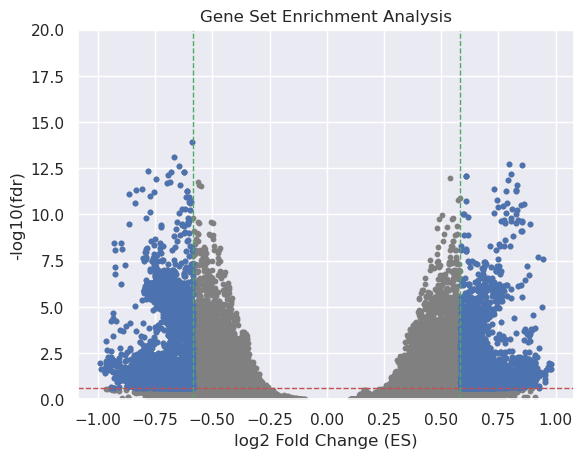

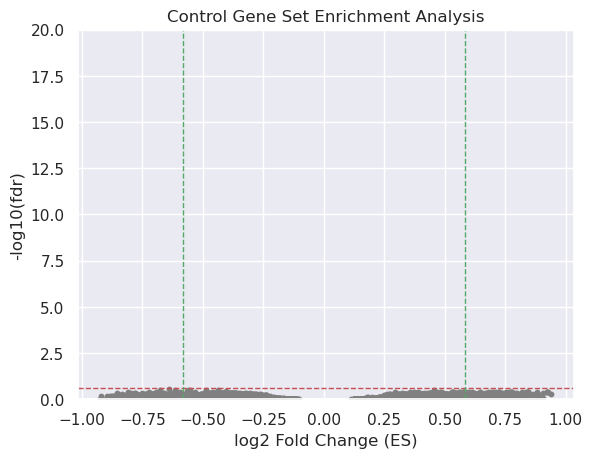

In [17]:
# Define cut-offs
lfc_cutoff = 0.584
fdr_cutoff = 0.25

    
plt.figure()
plt.scatter(x=all_GSEA_results_df['es'],y=all_GSEA_results_df['fdr'].apply(lambda x:-np.log10(x)),s=10, color='grey')
plt.scatter(x=significant_gsea_df['es'],y=significant_gsea_df['fdr'].apply(lambda x:-np.log10(x)),s=10)
#LFC and FDR lines
plt.axhline(y=-np.log10(fdr_cutoff), color='r', linestyle='--', linewidth=1)
plt.axvline(x=lfc_cutoff, color='g', linestyle='--', linewidth=1)
plt.axvline(x=-lfc_cutoff, color='g', linestyle='--', linewidth=1)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(fdr)')
plt.ylim(0,20)
plt.title('Gene Set Enrichment Analysis')

#save figure
gsea_save_path = pathlib.Path("../1.data-exploration/figures/gsea.png")
plt.savefig(gsea_save_path, bbox_inches="tight", dpi=600)


plt.figure()
plt.scatter(x=neg_GSEA_results_df['es'],y=neg_GSEA_results_df['fdr'].apply(lambda x:-np.log10(x)), s=10, color='grey')
plt.scatter(x=significant_negs['es'],y=significant_negs['fdr'].apply(lambda x:-np.log10(x)),s=10)
#LFC and FDR lines
plt.axhline(y=-np.log10(fdr_cutoff), color='r', linestyle='--', linewidth=1)
plt.axvline(x=lfc_cutoff, color='g', linestyle='--', linewidth=1)
plt.axvline(x=-lfc_cutoff, color='g', linestyle='--', linewidth=1)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(fdr)')
plt.ylim(0,20)
plt.title('Control Gene Set Enrichment Analysis')

#save figure
cgsea_save_path = pathlib.Path("../1.data-exploration/figures/controlgsea.png")
plt.savefig(cgsea_save_path, bbox_inches="tight", dpi=600)


In [18]:
# Using VAE generated data

pdf_path = pathlib.Path("../1.data-exploration/figures/gsea_plots.pdf")
pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_path)

# Looping over each dataframe in all_signatures to generate gsea plots for the chosen geneset with data 
# from each latent dimension and saving the plots to a singular pdf
for df in all_signatures:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "M Phase R-HSA-68886"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=False)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()


    fig_compact = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=True)
    pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

pdf.close()


# Using negative control

ctrl_pdf_path = pathlib.Path("../1.data-exploration/figures/ctrl_gsea_plots.pdf")
ctrl_pdf = matplotlib.backends.backend_pdf.PdfPages(ctrl_pdf_path)

# Looping over each dataframe in negative_control to generate gsea plots for the chosen geneset with data 
# from each latent dimension and saving the plots to a singular pdf
for df in negative_control:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "M Phase R-HSA-68886"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the negative control gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ctrl_pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=False)
    ctrl_pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    fig_compact = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=True)
    ctrl_pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    ctrl_pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

ctrl_pdf.close()